# Final Project for IBM Data Science Program

## My project: Find My Home 
### *The following is both my report and my notebook.*

## Section 1: Report

### Introduction

For my capstone project, I will be looking at the city of Sydney, Australia. The user that I have in mind is someone that is looking to decide on a neighborhood to move to. My goal is to be able to find the neighborhoods that best match the user. To accomplish this, I will be developing profiles for each neighborhood and matching it to the user's lifestyle preferences (selected via their top 5 important venue catgories to them). 

### Data

As was done in the previous modules, a data table with the coordinates and names of neighborhoods in Sydney is needed. I will start with an HTML table that is accessible via a search for this information. Then, we will use Foursquare data to get venue data for each area. This will be enough to develop a clustering of similar areas. 

A content-based recommendation system will then be developed using venue categories as the features of the neighborhood. No additional data will be needed. I will use a user profile to showcase the system's output given their top 10 venue categories. Below is my first step of getting the location data. 

Data will be processed using Python and associated libraries (scikit-learn, pandas, numpy, BeautifulSoup4, folium, and matplotlib). 

### Methodology

For data scraping, BeautifulSoup4 was employed. Data cleaning was performed to acquire a table of neighborhoods in Sydney with associated geographic coordinates and postal codes. 

Using the Foursquare API, this table was used to extract the nearby venues by category for each neighborhood in Sydney. With one-hot encoding, these categories were turned into dummy variables. The nearby venues were then grouped together so that every neighborhood row would have mean-weighted counts for each venue category. This data was further refined by only taking the highest 10 values for each neighborhood (e.g. the top 10 venue categories for that neighborhood).

With this processed data, a KMeans cluster analysis could be performed. These clusters create unsupervised relationships among neighborhoods.

Because KMeans clustering is not meant for the classification of data. It can't be used to apply our user data. Therefore, after the development of cluster labels. We can apply K-nearest neighbor methods to classify a user to a particular cluster. 

To get the user data, we can use the Foursquare API to pull a user account's visited venues undergo the same transformation as neighborhoods to achieve a list of top 10 venue categories for the user. With this information, the K-Nearest neighbor model can be developed with the neighborhood data and fitted to the user data. 

Based on the predicted cluster label for this user, the user will then have a list of neighborhoods that are best fitted to their lifestyle. 

### Results 

The first part of this project involved devloping a cluster analysis of the neighborhoods in Sydney utilizing venue category data in the areas. The elbow method was employed to decide on the best number of clusters. The graph that was produced had a very minor elbow, but it was decided that 8 was the best choice. After mapping the 8 clusters, it was apparent that one of the clusters was over represented in the more central part of Sydney. 

The second part of the project involved using the cluster labels as a target variable for a prediction model. Due to security protocols, it was only possible to use the author's Foursquare profile, which isn't used very regularly. The top 10 venue categories from this profile included place of residence and a category named 'building'. 

The training of the KNN model showed an accuracy of 0.74. It was able to place the user profile in the 2nd cluster. 

### Conclusion

By observation of the clusters, one cluster was too dominant in the central part of Sydney. This made it so that there was no way to differentiate many parts of Sydney. By observation of the top 10 venue categories of this major cluster, it is evident that cafes are a major factor in this cluster's definition. Because Sydney/Australia is well known for its cafe culture, a future refinement of this methodology would be to remove cafes from the list.  

The KNN model had a nearly 75% accuracy with K=5. This is a strong predictive model. The user was predicted to be in Cluster 2, which is one of the larger clusters. When this user lived in Sydney (never checking in using Foursquare there), the user had lived in neighborhoods that were in Cluster 2. So there is some accuracy to this prediction. It would have been more helpful to find a user that has a less city-based lifestyle to see if it could predict this. In general, more user data would have been helpful to test this model. 

Future steps in this project could work to connect a user to a more specific neighborhood in the cluster based on work proximity or average property cost (based on their budget/income). Another approach could be to integrate a recommendation system to help augment the weights of particular venue categories or even venues in the city itself. 

---
# Section 2. Coding the Project

### *Part 1. Getting the Data*

First, we will load our tools.

In [2]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py

In [3]:
!conda install -c conda-forge beautifulsoup4 --y
from bs4 import BeautifulSoup


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.3       |     pyhb0f4dca_0          86 KB  conda-forge
    soupsieve-2.0.1            |             py_1          30 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         116 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/noarch::beautifulsoup4-4.9.3-pyhb0f4dca_0
  soupsieve          conda-forge/noarch::soupsieve-2.0.1-py_1



beautifulsoup4-4.9.3 | 86 KB     | ##################################### | 100% 
soupsieve-2.0.1      | 30 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing

#### Now we are ready to go for the table from the HTML page

In [4]:
geo = requests.get('https://www.geonames.org/postal-codes/AU/NSW/new-south-wales.html')
geo.status_code

200

In [5]:
soup = BeautifulSoup(geo.content,'html.parser')

In [6]:
table = soup.find('table',class_='restable') #The Source Code in the HTML points to this as the table.

In [7]:
#Here we are taking each row's data elements (td) and stripping it of the text. 
table_rows = table.find_all('td')

def slice_per(source, step):
    return [source[i::step] for i in range(step)]

data = slice_per(table_rows,9) #Due to complexity of table structure, this function will separate out every 9th item for each soon-to-be column

The HTML list of td had a repetition of every 9 had all of the row information. (0 is #, 1 is Place, 2 is code, 3 is country, 4 is state, 5 is area, 6 is what broke the soup extraction, 7 nil, 8 is latlong.) 

Now, each list in the 'data' list needs to be formatted before being added to a column in a dataframe. We only need Place, Code, Area, and latlong. As part of this, the latlong list will need to be split into latitude and longitude.

In [8]:
#Let's remove the items that we don't need
del data[7]
del data[6]
del data[4]
del data[3]
del data[0]

In [9]:
#The main problem with most of them is the remaining HTML tags. Let's remove them.
for sublist in data:
    for i, s in enumerate(sublist):
        sublist[i] = str(s).replace('<td>','').replace('</td>','')

In [10]:
#The Latlong item has a lot more in it than just td tags. We need a different approach to get to the coordinates only.
import re

for i in range(len(data[3])):
    s = data[3][i]
    result = re.search('<small>(.*)</small>', s)
    data[3][i] = result.group(1)
    

In [11]:
df = pd.DataFrame({'Place':data[0],'Code':data[1],'Area':data[2],'Latlong':data[3]}) #Establish our dataframe

In [12]:
df[['Latitude','Longitude']] = df['Latlong'].str.split('/',expand=True) #Split Latitude and Longitude into separate columns

In [13]:
df.drop('Latlong',axis=1,inplace=True) #Finally remove Latlong column
df.head() #Complete!

,Place,Code,Area,Latitude,Longitude
0,Haymarket,2000,SYDNEY STREETS,-33.88,151.205
1,Ultimo,2007,SYDNEY STREETS,-33.881,151.198
2,Chippendale,2008,SYDNEY STREETS,-33.886,151.199
3,Pyrmont,2009,SYDNEY STREETS,-33.87,151.194
4,Surry Hills,2010,SYDNEY STREETS,-33.885,151.212


### Part 1b: Using Foursquare API to get neighborhood data.

In [14]:
CLIENT_ID = 'TL2OXZZZFEVI5ZZ3OSJYVWK0OXNL3WUJ0T2AEFP0R4URRYIU' # your Foursquare ID
CLIENT_SECRET = 'DIUONIWVFLWBU4KCVPR4VSFXC4Q0O24BZFGT1MDSQ4EJ0LSC' # your Foursquare Secret
ACCESS_TOKEN = 'F3BHRSKE1YPMZD3ST4XCQPNLLKTU1HFN53BDV4GBRSRFRXH5' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

limit = 100
radius = 500


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that we defined the function. We can use it to get venues in each neighborhood.

In [15]:
sydney_venues = getNearbyVenues(names=df['Place'], latitudes = df['Latitude'],longitudes = df['Longitude'])

Haymarket
Ultimo
Chippendale
Pyrmont
Surry Hills
Darlinghurst
Potts Point
Redfern
Waterloo
Zetland
Botany
Paddington
Bellevue Hill
Bondi
Bondi Beach
Randwick
Kingsford
Kensington
Coogee
Glebe
Balmain
North Sydney
Lane Cove
St Ives
Hornsby
Neutral Bay
Cremorne
Manly
Dee Why
Narrabeen
Mona Vale
Ryde
Macquarie Park
West Ryde
Marsfield
Ashfield
Burwood
Strathfield
Rhodes
Lidcombe
Auburn
Greystanes
Seven Hills
Blacktown
North Parramatta
Baulkham Hills
Kellyville
Fairfield
Cabramatta
Prestons
Liverpool
Greenacre
Belmore
Campsie
Lakemba
Yagoona
Bankstown
Dulwich Hill
Marrickville
Earlwood
Bexley
Peakhurst
Padstow
Revesby
Rockdale
Caringbah
Cronulla
Sutherland
Engadine
Woy Woy
Umina Beach
Terrigal
Bateau Bay
Wallsend
Charlestown
Merewether
Rutherford
East Maitland
Raymond Terrace
Cessnock
Muswellbrook
Armidale
Inverell
Gunnedah
Moree
Forster
Taree
Port Macquarie
Coffs Harbour
Grafton
Casino
Goonellabah
Byron Bay
Tweed Heads
Tweed Heads South
Wollongong
Woonona
Nowra
Campbelltown
Macquarie Fiel

Then we will perform one-hot encoding for the venue categories.

In [16]:
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

sydney_onehot['Neighborhood'] = sydney_venues['Neighborhood'] 

fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,Airfield,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basque Restaurant,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Night Market,Nightclub,Noodle House,Office,Organic Grocery,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roller Rink,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Singaporean Restaurant,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,

Below we will group by neighborhood so that each row is a neighborhood and contains the 0-1 weighted averge of all venue categories.

In [17]:
sydney_grouped = sydney_onehot.groupby('Neighborhood').mean().reset_index()

Now we need to re-organize the chart to show neighborhoods and the top 10 venue categories for them.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sydney_grouped['Neighborhood']

for ind in np.arange(sydney_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)

In [19]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annandale,Café,Grocery Store,Bar,Italian Restaurant,Bakery,Climbing Gym,Garden Center,Australian Restaurant,Snack Place,Asian Restaurant
1,Armidale,Café,Department Store,Shopping Mall,Pub,Italian Restaurant,Bank,Gym / Fitness Center,Diner,Fast Food Restaurant,Japanese Restaurant
2,Ashfield,Café,Dumpling Restaurant,Shanghai Restaurant,Malay Restaurant,Platform,Chinese Restaurant,Supermarket,Coffee Shop,Electronics Store,Japanese Restaurant
3,Auburn,Café,Grocery Store,Supermarket,Pizza Place,Fast Food Restaurant,Turkish Restaurant,Portuguese Restaurant,Lebanese Restaurant,Pakistani Restaurant,Middle Eastern Restaurant
4,Balmain,Café,Pub,Pizza Place,Bar,Sushi Restaurant,Park,Indian Restaurant,Ice Cream Shop,Bakery,Playground


Part 1 Complete!

### Part 2: Clustering 

Lets use this new chart to perform a K-means clustering. First we need to figure out how many clusters are best using the elbow method.

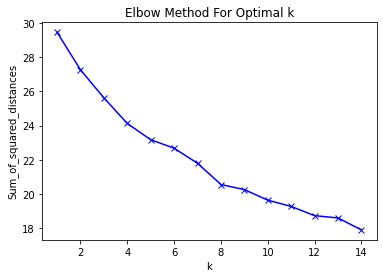

In [20]:
import matplotlib.pyplot as plt

sydney_grouped_clustering = sydney_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sydney_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The Elbow Method seems to show about 8 clusters is the best. 

In [21]:
# set number of clusters
kclusters = 8


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sydney_merged = df

In [22]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
sydney_merged = sydney_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Place')

sydney_merged.head() # check the last columns!

,Place,Code,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Haymarket,2000,SYDNEY STREETS,-33.88,151.205,0.0,Thai Restaurant,Café,Japanese Restaurant,Chinese Restaurant,Hotel,Korean BBQ Restaurant,Malay Restaurant,Hostel,Sushi Restaurant,Taiwanese Restaurant
1,Ultimo,2007,SYDNEY STREETS,-33.881,151.198,2.0,Café,Coffee Shop,Hotel,Ice Cream Shop,Supermarket,Dumpling Restaurant,Thai Restaurant,Japanese Restaurant,Malay Restaurant,Art Gallery
2,Chippendale,2008,SYDNEY STREETS,-33.886,151.199,2.0,Café,Bar,Coffee Shop,Pub,Hotel,Thai Restaurant,Burger Joint,Bakery,Australian Restaurant,Shopping Mall
3,Pyrmont,2009,SYDNEY STREETS,-33.87,151.194,2.0,Café,Fish Market,Japanese Restaurant,Australian Restaurant,Seafood Restaurant,Bar,Hotel,Italian Restaurant,Restaurant,Malay Restaurant
4,Surry Hills,2010,SYDNEY STREETS,-33.885,151.212,2.0,Café,Coffee Shop,Pub,Pizza Place,Sandwich Place,Korean Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Karaoke Bar


In [23]:
sydney_merged['Cluster Labels'].replace(np.nan,0,inplace=True)

Now, we can map the clusters!

In [24]:
sydney_merged['Latitude'] = sydney_merged['Latitude'].astype(float)
sydney_merged['Longitude'] = sydney_merged['Longitude'].astype(float)

sydney_merged.dtypes

Place                      object
Code                       object
Area                       object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [25]:
address = 'Sydney, New South Wales'

geolocator = Nominatim(user_agent="sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

sydney_merged[['Latitude','Longitude']].astype(float)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Latitude'], sydney_merged['Longitude'], sydney_merged['Place'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The first 3 clusters are defined below: 

* Cluster 0

In [26]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 0, sydney_merged.columns[[0] + list(range(5, sydney_merged.shape[1]))]]

,Place,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Haymarket,0.0,Thai Restaurant,Café,Japanese Restaurant,Chinese Restaurant,Hotel,Korean BBQ Restaurant,Malay Restaurant,Hostel,Sushi Restaurant,Taiwanese Restaurant
10,Botany,0.0,Bakery,Ice Cream Shop,Badminton Court,Chinese Restaurant,Coffee Shop,Film Studio,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
13,Bondi,0.0,Pizza Place,Bakery,Australian Restaurant,Italian Restaurant,Café,Grocery Store,Pub,Sporting Goods Shop,Brazilian Restaurant,Middle Eastern Restaurant
16,Kingsford,0.0,Chinese Restaurant,Indonesian Restaurant,Malay Restaurant,Thai Restaurant,Café,Korean Restaurant,Park,Grocery Store,Italian Restaurant,Bus Stop
17,Kensington,0.0,Burger Joint,Convenience Store,Indonesian Restaurant,Chinese Restaurant,Pizza Place,Kids Store,Gym / Fitness Center,Bus Stop,Sushi Restaurant,Malay Restaurant
22,Lane Cove,0.0,Fried Chicken Joint,Ice Cream Shop,Food,Wine Bar,Café,Middle Eastern Restaurant,Supermarket,Mexican Restaurant,Organic Grocery,Gym
28,Dee Why,0.0,Supermarket,Fast Food Restaurant,Pizza Place,Bowling Alley,Japanese Restaurant,Café,General Entertainment,Shopping Mall,Gym,Discount Store
31,Ryde,0.0,Café,Supermarket,Fast Food Restaurant,Department Store,Electronics Store,Pizza Place,Coffee Shop,Steakhouse,Korean Restaurant,Tea Room
33,West Ryde,0.0,Japanese Restaurant,Supermarket,Café,Thai Restaurant,Breakfast Spot,Italian Restaurant,Shopping Mall,Sandwich Place,Korean BBQ Restaurant,BBQ Joint
35,Ashfield,0.0,Café,Dumpling Restaurant,Shanghai Restaurant,Malay Restaurant,Platform,Chinese Restaurant,Supermarket,Coffee Shop,Electronics Store,Japanese Restaurant


* Cluster 1

In [27]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 1, sydney_merged.columns[[0] + list(range(5, sydney_merged.shape[1]))]]

,Place,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Bellevue Hill,1.0,Grocery Store,South American Restaurant,Park,Café,Italian Restaurant,Pizza Place,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
34,Marsfield,1.0,Park,Supermarket,Bus Stop,College Rec Center,Gas Station,Film Studio,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
37,Strathfield,1.0,Construction & Landscaping,Park,Music Venue,Astrologer,Yoga Studio,Film Studio,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
46,Kellyville,1.0,Playground,Park,Martial Arts School,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
60,Bexley,1.0,Convenience Store,Park,Pub,Music Store,Fruit & Vegetable Store,Filipino Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
80,Muswellbrook,1.0,Motel,Park,Golf Course,Fast Food Restaurant,Film Studio,Event Space,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish & Chips Shop
94,Tweed Heads South,1.0,Clothing Store,Electronics Store,Park,Auto Garage,Roller Rink,Outdoor Supply Store,Yoga Studio,Event Space,Falafel Restaurant,Farmers Market
97,Nowra,1.0,Motel,Convenience Store,Park,Fast Food Restaurant,Steakhouse,Cuban Restaurant,Cruise Ship,Creperie,Food Court,Food & Drink Shop
106,Wagga Wagga,1.0,Bakery,Park,Café,Furniture / Home Store,Australian Restaurant,Filipino Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
114,Quakers Hill,1.0,Bus Stop,Convenience Store,Park,Pizza Place,Yoga Studio,Filipino Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant


* Cluster 2

In [28]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 2, sydney_merged.columns[[0] + list(range(5, sydney_merged.shape[1]))]]

,Place,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ultimo,2.0,Café,Coffee Shop,Hotel,Ice Cream Shop,Supermarket,Dumpling Restaurant,Thai Restaurant,Japanese Restaurant,Malay Restaurant,Art Gallery
2,Chippendale,2.0,Café,Bar,Coffee Shop,Pub,Hotel,Thai Restaurant,Burger Joint,Bakery,Australian Restaurant,Shopping Mall
3,Pyrmont,2.0,Café,Fish Market,Japanese Restaurant,Australian Restaurant,Seafood Restaurant,Bar,Hotel,Italian Restaurant,Restaurant,Malay Restaurant
4,Surry Hills,2.0,Café,Coffee Shop,Pub,Pizza Place,Sandwich Place,Korean Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Karaoke Bar
5,Darlinghurst,2.0,Café,Italian Restaurant,Japanese Restaurant,Bar,Pub,Cocktail Bar,Bookstore,Ice Cream Shop,Bakery,Gym
6,Potts Point,2.0,Café,Hotel,Italian Restaurant,Pub,Supermarket,Australian Restaurant,Japanese Restaurant,Hostel,Thai Restaurant,Coffee Shop
7,Redfern,2.0,Café,Bar,Japanese Restaurant,Pub,Lounge,Pakistani Restaurant,Thai Restaurant,Theater,Donut Shop,Salon / Barbershop
8,Waterloo,2.0,Café,Gym,Pizza Place,Bakery,Vietnamese Restaurant,Thai Restaurant,Japanese Restaurant,Korean BBQ Restaurant,Restaurant,Park
9,Zetland,2.0,Café,Bus Stop,Park,Pizza Place,Gym,Mexican Restaurant,Supermarket,Shopping Mall,Fruit & Vegetable Store,Seafood Restaurant
11,Paddington,2.0,Café,Italian Restaurant,Bar,Pizza Place,Park,Bus Stop,Boutique,Pub,Australian Restaurant,Tennis Stadium


### Part 3: Fitting a User

#### Part 3a: Getting User Data / Preparing Data for Analysis

Now we need to work out a similar process of obtaining a list of top 10 venue categories but for a given user. We will use my own profile due to the security settings with accessing checkin data for other users.

In [30]:
CLIENT_ID = 'TL2OXZZZFEVI5ZZ3OSJYVWK0OXNL3WUJ0T2AEFP0R4URRYIU' # your Foursquare ID
CLIENT_SECRET = 'DIUONIWVFLWBU4KCVPR4VSFXC4Q0O24BZFGT1MDSQ4EJ0LSC' # your Foursquare Secret
ACCESS_TOKEN = 'F3BHRSKE1YPMZD3ST4XCQPNLLKTU1HFN53BDV4GBRSRFRXH5' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT2 = 250 # A default Foursquare API limit value

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

def getRecentVenues(USERID):
    
    place_list=[]

    # create the API request URL
    urll = 'https://api.foursquare.com/v2/users/{}/checkins?oauth_token={}&client_id={}&client_secret={}&v={}&limit={}'.format(
                  USERID,
                  ACCESS_TOKEN,
                  CLIENT_ID, 
                  CLIENT_SECRET, 
                  VERSION, 
                  LIMIT2)
            
    # make the GET request
    results = requests.get(urll).json()["response"]['checkins']['items']
        
    # return only relevant information for each nearby venue
    place_list.append([(USERID,
        v['venue']['name'],  
        v['venue']['categories'][0]['name']) for v in results])

    recent_places = pd.DataFrame([item for place_list in place_list for item in place_list])
    recent_places.columns = ['User',
                  'Venue', 
                  'Venue Category']
    
    return(recent_places)

In [31]:
user = 'self' #due to permissions we will use my own Foursquare checkins

userplaces = getRecentVenues(user)

In [32]:
user_onehot = pd.get_dummies(userplaces[['Venue Category']], prefix="", prefix_sep="")

user_onehot['User'] = userplaces['User'] 

fixed_columns = [user_onehot.columns[-1]] + list(user_onehot.columns[:-1])
user_onehot = user_onehot[fixed_columns]

user_onehot.head()

,User,Airport,Airport Gate,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Big Box Store,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Café,Capitol Building,City,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Library,Concert Hall,Convention Center,Corporate Cafeteria,Cosmetics Shop,Department Store,Design Studio,Diner,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gay Bar,Grocery Store,Gym,Home (private),Hospital,Hotel,Indian Restaurant,Italian Restaurant,Juice Bar,Korean Restaurant,Library,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Multiplex,Music Festival,Music Venue,Neighborhood,New American Restaurant,Noodle House,Park,Pizza Place,Platform,Plaza,Pub,Residential Building (Apartment / Condo),Sandwich Place,Science Museum,Sculpture Garden,Shopping Mall,Street Food Gathering,Supermarket,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vietnamese Restaurant
0,self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,self,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
user_grouped = user_onehot.groupby('User').mean().reset_index()
user_grouped.head()

,User,Airport,Airport Gate,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Big Box Store,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Café,Capitol Building,City,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Library,Concert Hall,Convention Center,Corporate Cafeteria,Cosmetics Shop,Department Store,Design Studio,Diner,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gay Bar,Grocery Store,Gym,Home (private),Hospital,Hotel,Indian Restaurant,Italian Restaurant,Juice Bar,Korean Restaurant,Library,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Multiplex,Music Festival,Music Venue,Neighborhood,New American Restaurant,Noodle House,Park,Pizza Place,Platform,Plaza,Pub,Residential Building (Apartment / Condo),Sandwich Place,Science Museum,Sculpture Garden,Shopping Mall,Street Food Gathering,Supermarket,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vietnamese Restaurant
0,self,0.084,0.004,0.02,0.008,0.008,0.008,0.004,0.004,0.004,0.004,0.004,0.004,0.044,0.012,0.016,0.008,0.012,0.008,0.004,0.02,0.004,0.008,0.004,0.004,0.004,0.004,0.004,0.004,0.008,0.004,0.004,0.004,0.004,0.004,0.004,0.008,0.012,0.008,0.016,0.056,0.02,0.012,0.048,0.004,0.016,0.004,0.004,0.004,0.016,0.012,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.012,0.012,0.008,0.008,0.004,0.004,0.004,0.196,0.012,0.004,0.004,0.072,0.004,0.004,0.008,0.012,0.008,0.004,0.004


In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['User']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
user_venues_sorted = pd.DataFrame(columns=columns)
user_venues_sorted['User'] = user_grouped['User']

for ind in np.arange(user_grouped.shape[0]):
    user_venues_sorted.iloc[ind, 1:] = return_most_common_venues(user_grouped.iloc[ind, :], num_top_venues)

In [35]:
user_venues_sorted.head()

,User,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,self,Residential Building (Apartment / Condo),Airport,Shopping Mall,Gym,Hotel,Building,American Restaurant,Home (private),Coffee Shop,Mediterranean Restaurant


#### Part 3b: Predicting Location

Now that we have a list of top 10 venue categories for a user. We can utilize K-Nearest Neighbor to predict the Cluster Label that the user would receive based on the Neighborhood Venue Category table. 

In [36]:
new_sydney_grouped = sydney_grouped
new_sydney_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
new_sydney_grouped.head() #Now we have a single data frame that can be used for training the model.

,Cluster Labels,Neighborhood,ATM,Adult Boutique,African Restaurant,Airfield,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basque Restaurant,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Night Market,Nightclub,Noodle House,Office,Organic Grocery,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roller Rink,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Singaporean Restaurant,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Resta

Now we need to get the user data to look just like this table since the KNN model will be based on all of these categories. Currently the grouped user dataframe doesn't have all of these variables. 

In [64]:
# Get user_grouped to have the same number of column variables as sydney_grouped and set it equal to Xuser
newusergrouped = user_grouped.drop('Neighborhood',axis=1)

userformatcolumns = sydney_grouped.columns

for col in userformatcolumns:
    if col not in newusergrouped.columns:
        newusergrouped[col] = 0
    else:
        continue

newusergrouped = newusergrouped.rename(columns={'User':'Neighborhood'})
newusergrouped = newusergrouped.loc[:,~newusergrouped.columns.duplicated()]

excessnew = sydney_grouped.append(newusergrouped, ignore_index=True, sort=False)
excessnew.replace(np.nan,0,inplace=True)


,Cluster Labels,Neighborhood,ATM,Adult Boutique,African Restaurant,Airfield,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basque Restaurant,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Night Market,Nightclub,Noodle House,Office,Organic Grocery,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roller Rink,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Singaporean Restaurant,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Resta

In [87]:
testset = excessnew.iloc[0:194]

#Lets finish with Xuser being defined as the X set for prediction of the cluster label
Xuser = excessnew.drop(['Cluster Labels','Neighborhood'],axis=1).iloc[194]
#Lets finish with the rest of the dataframe formatted to X and Y set for test fitting
Xtestset = testset.drop(['Cluster Labels','Neighborhood'],axis=1)
Ytestset = testset['Cluster Labels']

From here, we can create the KNN model. We will first split the neighborhood data to help train the model. Then we will determine the best K value to use. Finally, we will use that K value to train with the entire neighborhood data set. This will allow us to predict the Cluster Label for the user.

In [100]:
X = Xtestset.values
Y = Ytestset.values

XuserFit = Xuser.values.reshape(1,-1)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=4)


Best accuracy: 0.7435897435897436 with k= 5


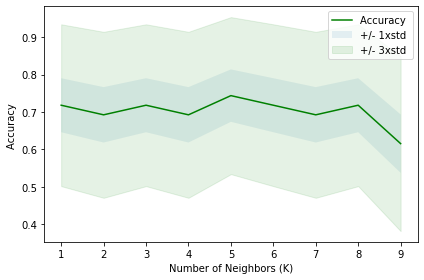

In [93]:
from sklearn import metrics

Ks = 10 #max value you want to try
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat = neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print ( "Best accuracy:", mean_acc.max(), "with k=", mean_acc.argmax()+1)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()


From this training of the data, we have found the best accuracy is achieved with k=5. Our final step is to create the KNN model with k=5 and our data and predict that cluster label using our User data.

In [105]:
k2 = 5 

neigh = KNeighborsClassifier(n_neighbors=k2).fit(x_train,y_train)
yhat = neigh.predict(XuserFit)
print(yhat)

[2]


We have finally reached the end. The most favorable matched cluster for the user is Cluster 2. 